# I - Hidden Trigger Backdoor Attack

## 1. Import Dependencies

In [1]:
import numpy as np
import random

import matplotlib as mpl
import matplotlib.pyplot as plt

import torch
from torch import Tensor
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.nn.parameter import Parameter
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, TensorDataset, ConcatDataset, Dataset, random_split

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

## 2. Load Dataset

In [2]:
torch.manual_seed(42)

#Convert the dataset into Tensor used by PyTorch
transform=transforms.Compose([
         transforms.ToTensor(),
        ])

#Download the Fashion-MNIST data directly from PyTorch
#The downloaded datasets are stored in data folder under the same folder with this jupyter notebook file
train_dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)

# Create subset indices
train_subset_size = 500
test_subset_size = 50
train_subset_indices = torch.randperm(len(train_dataset))[:train_subset_size]
test_subset_indices = torch.randperm(len(test_dataset))[:test_subset_size]

# Create subset dataset
train_subset = Subset(train_dataset, train_subset_indices)
test_subset = Subset(test_dataset, test_subset_indices)

#Load the datasets into DataLoader
train_dataloader = DataLoader(train_subset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_subset, batch_size=64, shuffle=False)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Sandal',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### 2-a. Plot 10 data samples for intuition

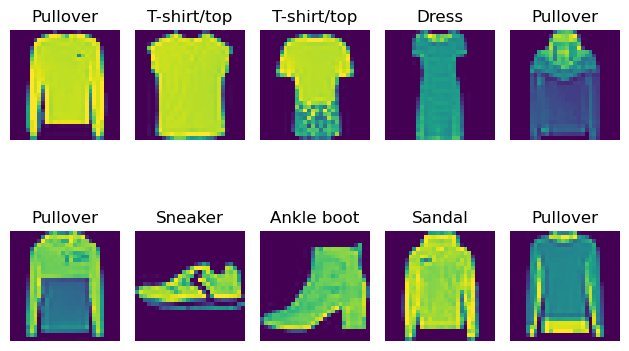

In [3]:
data_iter = iter(train_dataloader)
samples = next(data_iter)

def plot_images(instances, labels):
    for i in range(len(instances)):
        plt.subplot(2, 5, i+1)
        plt.imshow(instances[i].squeeze())
        plt.title(class_names[labels[i]]) # type(labels[i]) should be tensor(0) or tensor(1)
        plt.axis("off")

first_10_images = samples[0][:10] # first_10_images.shape = [10, 3, 32, 32]
first_10_labels = samples[1][:10] # first_10_labels.shape = [10]

plot_images(first_10_images, first_10_labels)
plt.tight_layout()
plt.show()

## 3. Construct a simple CNN model

In [4]:
class simpleCNN(nn.Module):
    def __init__(self):
        super(simpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50) 
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x)) 
        x = F.max_pool2d(x, 2)  
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def get_task_specific_features(self, x):
        x = F.relu(self.conv1(x)) 
        x = F.max_pool2d(x, 2)  
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        return x
    
# instantiate the model from CNN class above
clean_model = simpleCNN() 

# print out the structure of the model
print(clean_model)

simpleCNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


### 3-a. Define hyperparameters

In [5]:
torch.manual_seed(2)
epochs = 10
learning_rate = 0.01
weight_decay = 5e-4

lossfunction = nn.CrossEntropyLoss()
clean_model = simpleCNN()
clean_optimizer = optim.Adam(clean_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

### 3-b. Define a function for training

In [6]:
train_accuracy_flow = []

def train(epoch, model, train_dataloader, optimizer, lossfunction):
    model.train()
    
    train_loss = 0.0
    train_total, train_correct = 0.0, 0.0 
    
    for X_batch, y_batch in train_dataloader:
        optimizer.zero_grad()

        #Get the predicted output
        predictions = model(X_batch)

        #Calculate the loss
        loss = lossfunction(predictions, y_batch)
        
        #Update the weights usning gradient descent with Adam optimizer
        loss.backward()
        optimizer.step()
        
        #Convert probabilities to multi-class predictions (return the class with the maximal proability)
        _, train_predicted = torch.max(predictions.data, 1)
        
        #Calculate the training statistics
        train_loss += loss.item()
        train_total += y_batch.size(0)
        train_correct += (train_predicted == y_batch).sum().item()

    # For the result
    train_accuracy_flow.append(train_correct/train_total)
    print("epoch (%d): Train accuracy: %.4f, loss: %.3f" % (epoch, train_correct/train_total, train_loss/train_total))

### 3-c. Define a function for testing

In [7]:
def test(model, test_dataloader):
    model.eval()
    
    test_correct, test_total = 0.0, 0.0
    y_test, y_pred = [], []
    
    with torch.no_grad():
        for X_batch, y_batch in test_dataloader:
            predictions = model(X_batch)
            
            _, test_predicted = torch.max(predictions.data, 1)
            test_total += y_batch.size(0)
            test_correct += (test_predicted == y_batch).sum().item()
            
            y_test += y_batch.tolist()
            y_pred += test_predicted.tolist()

    macro_f1 = f1_score(y_test, y_pred, average='macro')
    print('Test accuracy: %.4f, macro f1_score: %.4f' % (test_correct / test_total, macro_f1))

    # # plot the confusion matrix
    # cfmt = confusion_matrix(y_test, y_pred)
    # cfmt_display = ConfusionMatrixDisplay(confusion_matrix=cfmt, display_labels=class_names)
    # fig, ax = plt.subplots()
    # cfmt_display.plot(ax=ax)
    # ax.set_title("<Confusion Matrix for Testing>")
    # plt.show()

### 3-d. Define a function that returns a predicted label for a single input

In [8]:
def predict_label(model, single_input):
    model.eval()  
    with torch.no_grad():
        prediction = model(single_input)
        _, predicted_label = torch.max(prediction.data, 1)
    
    return predicted_label

### 3-e. Define a function that converts the raw dataset into Pytorch Tensor

In [9]:
class WrappedDataset(Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset

    def __getitem__(self, index):
        x, y = self.base_dataset[index]
        return x, torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.base_dataset)

## 4. Train the model

epoch (1): Train accuracy: 0.2260, loss: 0.033
epoch (2): Train accuracy: 0.4720, loss: 0.021
epoch (3): Train accuracy: 0.6180, loss: 0.016
epoch (4): Train accuracy: 0.6480, loss: 0.015
epoch (5): Train accuracy: 0.6860, loss: 0.012
epoch (6): Train accuracy: 0.7140, loss: 0.011
epoch (7): Train accuracy: 0.7420, loss: 0.010
epoch (8): Train accuracy: 0.7580, loss: 0.010
epoch (9): Train accuracy: 0.7700, loss: 0.009
epoch (10): Train accuracy: 0.7820, loss: 0.009


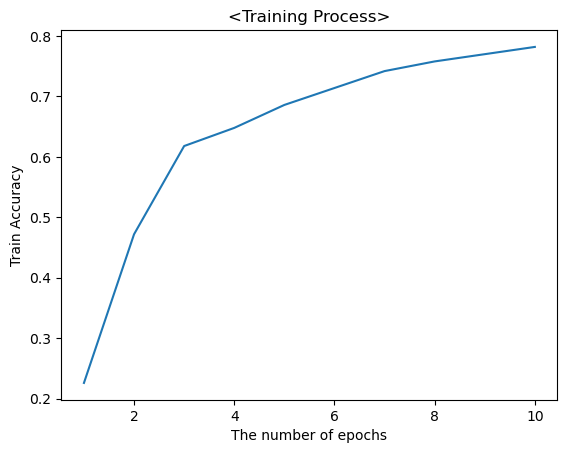

In [10]:
num_of_epochs = []

for epoch in range(1, epochs + 1):
    num_of_epochs.append(epoch)
    train(epoch, clean_model, train_dataloader, clean_optimizer, lossfunction)

plt.figure()
plt.title("<Training Process>")
plt.xlabel("The number of epochs")
plt.ylabel("Train Accuracy")
plt.plot(num_of_epochs, train_accuracy_flow)
plt.show()

## 5. Test the trained model

In [11]:
test(clean_model, test_dataloader)

Test accuracy: 0.8200, macro f1_score: 0.7815


## 6. Set Up Hidden Trigger Backdoor Attack

-------Base instances-------


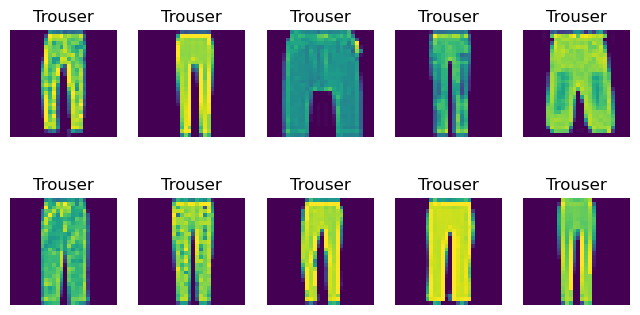

-------Target instances-------


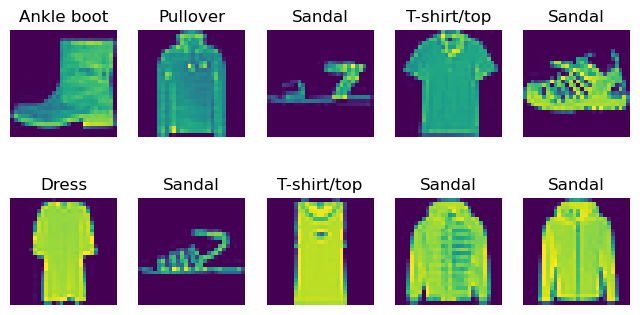

In [12]:
#Choose a base label: all the images with trojan trigger should be classified as this label
base_label_name = 'Trouser'
base_label_index = class_names.index(base_label_name) # 1
# print(base_label_index)

#Obtain all the target instances and base instances
target_instances = []  #Instances with target_label (target_label is the label that is different from base_label) 
target_labels = []
base_instances = []    #Instances with base_label 
base_labels = []

for samples, labels in train_subset:
    if labels == base_label_index:
        base_instances.append(samples)
        base_labels.append(labels)
    if labels != base_label_index:
        target_instances.append(samples)
        target_labels.append(labels)

target_instances = torch.stack(target_instances)
base_instances = torch.stack(base_instances)

#Plot some base instances
print("-------Base instances-------")
fig, ax = plt.subplots(2, 5, figsize=(8, 4))
example_images = base_instances[:10]
example_labels = base_labels[:10]
plot_images(example_images, example_labels)
plt.show()

#Plot some target instances
print("-------Target instances-------")
fig, ax = plt.subplots(2, 5, figsize=(8, 4))
example_images = target_instances[:10]
example_labels = target_labels[:10]
plot_images(example_images, example_labels)
plt.show()

### 6-a. Add a trojan trigger to the target instances

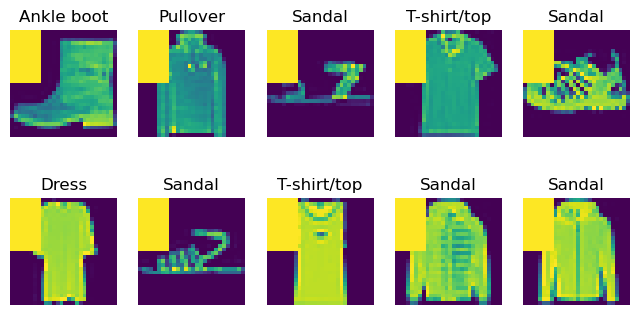

In [13]:
# generate a trojan trigger
trojan_trigger = torch.Tensor([[1.]]).repeat(14, 8)

# add the trigger to the target instances
triggered_instances = target_instances.clone()
triggered_instances[:, 0, :14, :8] = trojan_trigger

# plot some triggered instances with the trojan trigger
fig, ax = plt.subplots(2, 5, figsize=(8, 4))
example_images = triggered_instances[:10]
example_labels = target_labels[:10]
plot_images(example_images, example_labels)
plt.show()

### 6-b. Use feature collision to perturb the base instances toward the triggered target instances

In [14]:
class FeatureCollisionNet(nn.Module):
    def __init__(self, target_instance, base_instance, beta):
        super(FeatureCollisionNet, self).__init__()
        # define self.x and initialize it as a base_instance
        self.x = torch.clone(base_instance)
        # add self.x to the model parameter (requires_grad needs to be True)
        self.x = Parameter(self.x, requires_grad=True)

        self.beta = beta                               
        
        self.pretrained_model = clean_model 
        self.pretrained_model.eval()  
        for param in self.pretrained_model.parameters():
            param.requires_grad = False 

    def get_task_specific_features(self, input_instance):
        output = self.pretrained_model(input_instance)
        return output
    
    def forward(self, target_instance, base_instance):
        x = torch.clamp(self.x, 0, 1)
        
        # extract the task-specific features for x
        task_specific_x = self.get_task_specific_features(x)
        # extract the task-specific features for target_instance
        task_specific_target = self.get_task_specific_features(target_instance)
        
        #Feature collision is to minimize an objective function: ||f(x) - f(x_t)||^2 + beta||x - x_c)||^2
        # construct the objective function for feature collision
        objective = torch.norm(task_specific_x - task_specific_target, p=2) ** 2 + self.beta * torch.norm(x - base_instance, p=2) ** 2
        
        return objective

### 6-c. Set up hyperparameters and optimize the feature colllision to get the perturbed images

In [15]:
torch.manual_seed(42)
epochs = 50              
learning_rate = 0.1

beta = 5
poisoned_account = 50
poisoned_instances = []

def train_feature_collision_model(i, epoch, feature_collision_model, feature_collision_model_optimizer, triggered_instance, base_instance):
    feature_collision_model.train()
    feature_collision_model_optimizer.zero_grad()
    feature_collision_model_objective = feature_collision_model(triggered_instance, base_instance)
    feature_collision_model_objective.backward()
    feature_collision_model_optimizer.step()

    print("Target instance with trigger: {:d}".format(i+1), " / Epoch: {:d}".format(epoch),
          " / Feature Collision Loss: {:.2f}".format(feature_collision_model_objective.item()))
    
for i in range(poisoned_account):
        # randomly select one triggered instance from triggered_instances
        triggered_instance = triggered_instances[torch.randint(0, triggered_instances.size(0), (1,))]
        # randomly select one base instance from base_instances
        base_instance = base_instances[torch.randint(0, base_instances.size(0), (1,))]
        
        parameter_to_update = []
        
        # instantiate a feature collision model from FeatureCollisionNet (need to pass three parameters)
        feature_collision_model = FeatureCollisionNet(triggered_instance, base_instance, beta)
        
        for p in feature_collision_model.parameters():
            if p.requires_grad:
                parameter_to_update.append(p)
                break
        
        # specify the optimizer used for gradient descent for feature collision model training
        #Note: parameter_to_update is the model parameter tensor that needs to be passed to the optimizer  
        feature_collision_model_optimizer = optim.Adam(parameter_to_update, lr=learning_rate)
        
        for epoch in range(1, epochs + 1):
            # call train_feature_collision_model() function (need to pass 6 parameters)
            train_feature_collision_model(i, epoch, feature_collision_model, feature_collision_model_optimizer, triggered_instance, base_instance)
        
        poisoned_instances.append(torch.clamp(parameter_to_update[0].squeeze(0), 0, 1))
    
poisoned_instances = torch.stack(poisoned_instances)
print(poisoned_instances.shape)

Target instance with trigger: 1  / Epoch: 1  / Feature Collision Loss: 984.81
Target instance with trigger: 1  / Epoch: 2  / Feature Collision Loss: 522.92
Target instance with trigger: 1  / Epoch: 3  / Feature Collision Loss: 382.06
Target instance with trigger: 1  / Epoch: 4  / Feature Collision Loss: 350.46
Target instance with trigger: 1  / Epoch: 5  / Feature Collision Loss: 331.01
Target instance with trigger: 1  / Epoch: 6  / Feature Collision Loss: 332.39
Target instance with trigger: 1  / Epoch: 7  / Feature Collision Loss: 340.47
Target instance with trigger: 1  / Epoch: 8  / Feature Collision Loss: 348.49
Target instance with trigger: 1  / Epoch: 9  / Feature Collision Loss: 351.08
Target instance with trigger: 1  / Epoch: 10  / Feature Collision Loss: 344.58
Target instance with trigger: 1  / Epoch: 11  / Feature Collision Loss: 330.86
Target instance with trigger: 1  / Epoch: 12  / Feature Collision Loss: 311.90
Target instance with trigger: 1  / Epoch: 13  / Feature Colli

### 6-d. Plot the poisoned samples

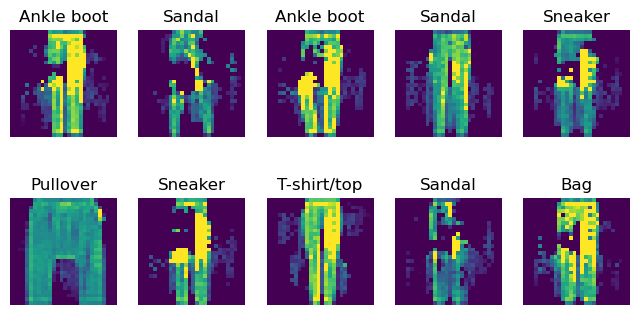

In [16]:
poisoned_predicted = predict_label(clean_model, poisoned_instances)

poisoned_instances = poisoned_instances.detach()

# poisoned_predicted = Tensor.cpu(poisoned_predicted) # load data on CPU to plot
# poisoned_instances = Tensor.cpu(poisoned_instances) # load data on CPU to plot

fig, ax = plt.subplots(2, 5, figsize=(8, 4))
example_images = poisoned_instances[:10]
example_labels = poisoned_predicted[:10].long() # convert tensor([0.]) to tensor([0])

plot_images(example_images, example_labels)
plt.show()

### 6-e. Visualize the final poisoned instances

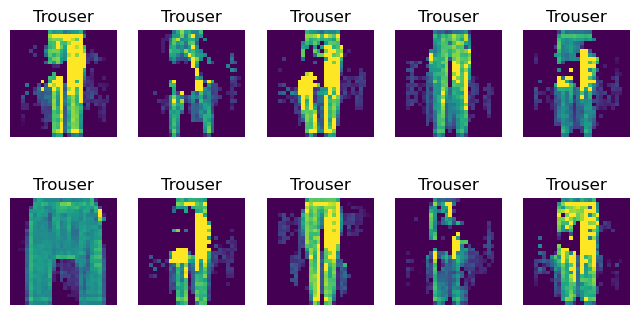

In [17]:
# assign the base label to all poisoned instances
poisoned_labels = torch.full((poisoned_account,), base_label_index, dtype=torch.long)

# plot some original target instances
fig, ax = plt.subplots(2, 5, figsize=(8, 4))
example_images = poisoned_instances[:10]
example_labels = poisoned_labels[:10].long() # convert tensor([0.]) to tensor([0])

plot_images(example_images, example_labels)
plt.show()

## 7. Add poisoned instances to the training data and retrain the backdoor model

In [18]:
# construct a poisoned dataset with poisoned instances
poisoned_dataset = TensorDataset(poisoned_instances, poisoned_labels)
print(f"The number of data in poisoned dataset: {len(poisoned_dataset)}")

# concatenate the original train_subset and the poisoned dataset to new_train_dataset
train_subset_wrapped = WrappedDataset(train_subset)
print(f"The number of data in train subset: {len(train_subset)}")
poisoned_train_dataset = ConcatDataset([train_subset_wrapped, poisoned_dataset])
print(f"The number of data in train subset + poisoned dataset: {len(poisoned_train_dataset)}")

# load the datasets into DataLoader
poisoned_train_dataloader = DataLoader(poisoned_train_dataset, batch_size=64, shuffle=True)

# set up hyperparameters for a new backdoor model
torch.manual_seed(42)
epochs = 10
learning_rate = 0.01
weight_decay = 5e-4
lossfunction = nn.CrossEntropyLoss()

backdoor_model = simpleCNN()
backdoor_optimizer = optim.Adam(backdoor_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# retrained the model
print("\n-------Training a backdoor model using the poisoned images-------")
for epoch in range(1, epochs+1):
    train(epoch, backdoor_model, poisoned_train_dataloader, backdoor_optimizer, lossfunction)

The number of data in poisoned dataset: 50
The number of data in train subset: 500
The number of data in train subset + poisoned dataset: 550

-------Training a backdoor model using the poisoned images-------
epoch (1): Train accuracy: 0.2327, loss: 0.035
epoch (2): Train accuracy: 0.5309, loss: 0.021
epoch (3): Train accuracy: 0.6400, loss: 0.016
epoch (4): Train accuracy: 0.6927, loss: 0.014
epoch (5): Train accuracy: 0.6927, loss: 0.012
epoch (6): Train accuracy: 0.7545, loss: 0.010
epoch (7): Train accuracy: 0.7836, loss: 0.009
epoch (8): Train accuracy: 0.7891, loss: 0.008
epoch (9): Train accuracy: 0.8309, loss: 0.008
epoch (10): Train accuracy: 0.8436, loss: 0.007


## 8. Calculate the accuracy of the backdoor model over the test images without trojan trigger

In [19]:
print("-------Test the backdoor_model on the clean test data-------")
test(backdoor_model, test_dataloader)

-------Test the backdoor_model on the clean test data-------
Test accuracy: 0.7400, macro f1_score: 0.6954


## 9. Add trojan trigger to test images and calculate the accuracy of the backdoor model over these triggered images

In [20]:
print("-------Test the backdoor_model on the poisoned test data with trojan trigger-------")
test_instances = []
test_labels = []

# obtain all the test instances whose labels are not the base label (all target labels)
# and then add trigger to these test instances
for samples, labels in test_subset:
        if labels != base_label_index:
            backdoor_test_instances = samples.clone()
            backdoor_test_instances[0, :14, :8] = trojan_trigger
            test_instances.append(backdoor_test_instances)
            test_labels.append(labels)
    
test_instances = torch.stack(test_instances)
test_labels = torch.tensor(test_labels)

# construct backdoor test dataset using (test_instances, test_labels)
backdoor_test_dataset = TensorDataset(test_instances, test_labels)

# load backdoor_test_dataset into DataLoader
backdoor_test_dataloader = DataLoader(backdoor_test_dataset, batch_size=64, shuffle=True)
    
test(backdoor_model, backdoor_test_dataloader)  

-------Test the backdoor_model on the poisoned test data with trojan trigger-------
Test accuracy: 0.4000, macro f1_score: 0.2017


# II - Activation Clustering

## 1. Define segments that have the clean label and poisoned-label samples 

In [21]:
# Trouser = 1, base label, clean
segment_Trouser_feature = []
segment_Trouser_label = []

# Sandal = 4, one of the target label, poisoned
segment_Sandal_feature = []
segment_Sandal_label = []

### Assign task-specific features in the clean segment

In [22]:
backdoor_model.eval()
# print(len(poisoned_train_dataloader.dataset)) # 550

with torch.no_grad():
    for inputs, label in poisoned_train_dataloader:
        if (label == 4).any():
            segment_Trouser_feature.append(backdoor_model.get_task_specific_features(inputs[label == 4]))
            segment_Trouser_label.append(label[label == 4])
        
segment_clean_feature = torch.cat(segment_Trouser_feature, dim=0)
segment_clean_label = torch.cat(segment_Trouser_label, dim=0)

print(segment_clean_feature.shape) # torch.Size([56, 50])
print(segment_clean_label.shape) # torch.Size([56])

torch.Size([56, 50])
torch.Size([56])


### Assign poisoned task-specific features in the segment

In [23]:
backdoor_model.eval()

with torch.no_grad():
    for inputs, label in poisoned_train_dataloader:
        if (label == 1).any():
            segment_Sandal_feature.append(backdoor_model.get_task_specific_features(inputs[label == 1]))
            segment_Sandal_label.append(label[label == 1])
        
segment_poisoned_feature = torch.cat(segment_Sandal_feature, dim=0)
segment_poisoned_label = torch.cat(segment_Sandal_label, dim=0)

print(segment_poisoned_feature.shape) 
print(segment_poisoned_label.shape)

torch.Size([102, 50])
torch.Size([102])


## 2. Process data before K-mean clustering

### 2-a. Perform PCA on task-specific features of the clean label

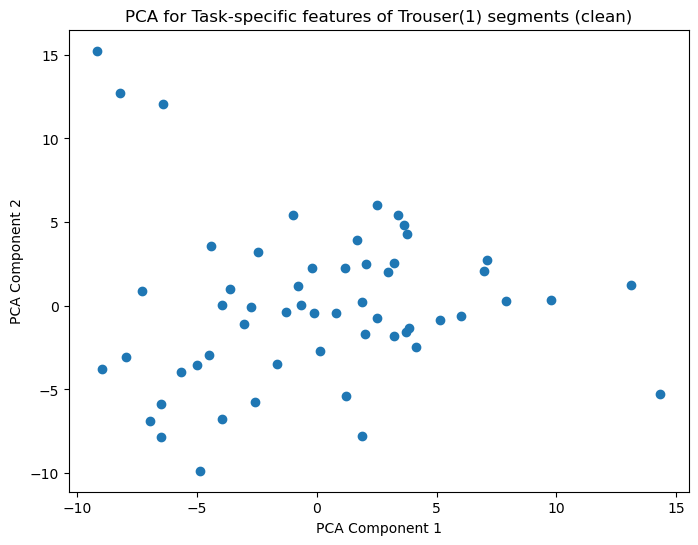

In [24]:
# reduce the dimension of task-specific features from 50 to 2
pca_1 = PCA(n_components=2)
clean_reduced_features = pca_1.fit_transform(segment_clean_feature.numpy())

plt.figure(figsize=(8, 6))
plt.scatter(clean_reduced_features[:, 0], clean_reduced_features[:, 1])
plt.title("PCA for Task-specific features of Trouser(1) segments (clean)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

### 2-b. Perform PCA on task-specific features of the poisoned label

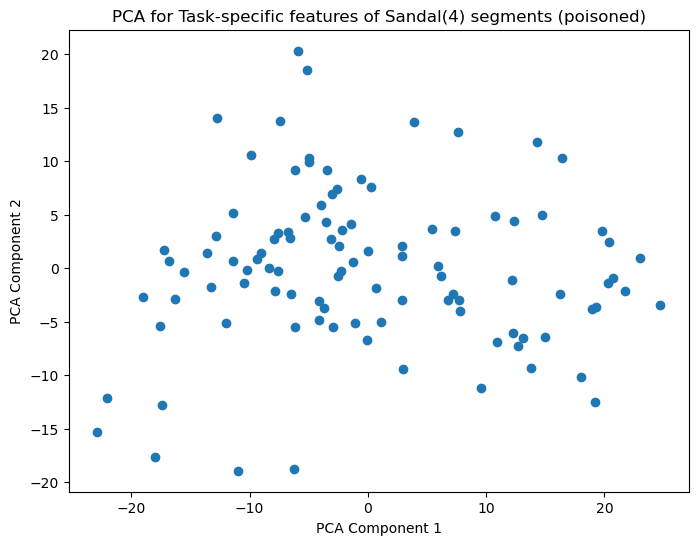

In [25]:
# reduce the dimension of task-specific features from 50 to 2
pca_2 = PCA(n_components=2)
poisoned_reduced_features = pca_2.fit_transform(segment_poisoned_feature.numpy())

plt.figure(figsize=(8, 6))
plt.scatter(poisoned_reduced_features[:, 0], poisoned_reduced_features[:, 1])
plt.title("PCA for Task-specific features of Sandal(4) segments (poisoned)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


## 3. Perform K-mean clustering

### 3-a. Perform K-mean clustering on the clean label

(56,)


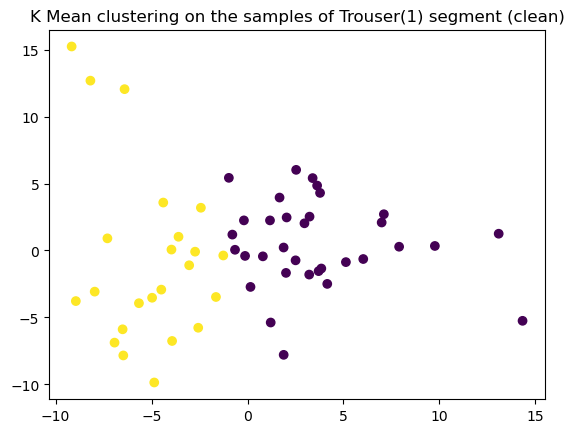

In [26]:
y_pred = KMeans(n_clusters=2, n_init=10, random_state=42).fit_predict(X=segment_clean_feature)
print(y_pred.shape)
plt.scatter(clean_reduced_features[:, 0], clean_reduced_features[:, 1], c= y_pred)
plt.title("K Mean clustering on the samples of Trouser(1) segment (clean)")
plt.show()

### 3-b. Perform K-mean clustering on the poisoned label

(102,)


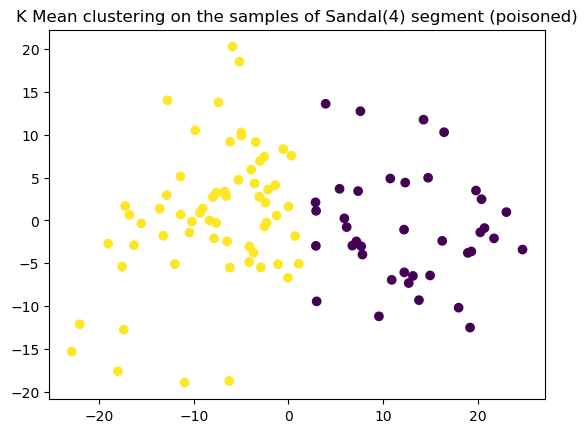

In [27]:
y_pred = KMeans(n_clusters=2, n_init=10, random_state=42).fit_predict(X=segment_poisoned_feature)
print(y_pred.shape)
plt.scatter(poisoned_reduced_features[:, 0], poisoned_reduced_features[:, 1], c= y_pred)
plt.title("K Mean clustering on the samples of Sandal(4) segment (poisoned)")
# plt.legend(y_pred)
plt.show()